<a href="https://colab.research.google.com/github/Katy-Kittivibul/Sentiment-Analysis-COVID-19-vaccines-Tweets-/blob/main/Twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis for COVID-19 All Vaccines Tweets**
This dataset collected tweets about all COVID-19 Vaccines including:
- Pfizer/BioNTech
- Sinopharm
- Sinovac
- Moderna
- Oxford/AstraZeneca
- Covaxin
- Sputnik V

Dataset Link: https://www.kaggle.com/datasets/gpreda/all-covid19-vaccines-tweets/data

## Import data

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import plotly.express as px
import seaborn as sns

from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpreda/all-covid19-vaccines-tweets")

print("Path to dataset files:", path)

100%|██████████| 29.9M/29.9M [00:00<00:00, 54.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpreda/all-covid19-vaccines-tweets/versions/113


In [4]:
# List files in the directory

files = os.listdir(path)
print("Files in the dataset folder:", files)

Files in the dataset folder: ['vaccination_all_tweets.csv']


In [5]:
for file in files:
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        print(f"Reading file: {dataset_path}")

        # Load the CSV file into a DataFrame
        data = pd.read_csv(dataset_path)

Reading file: /root/.cache/kagglehub/datasets/gpreda/all-covid19-vaccines-tweets/versions/113/vaccination_all_tweets.csv


## Data cleaning

In [6]:
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [7]:
# Check column names
data.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [8]:
# Check number of rows and column
data.shape

(228207, 16)

In [9]:
# Check null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                228207 non-null  int64 
 1   user_name         228205 non-null  object
 2   user_location     161296 non-null  object
 3   user_description  211184 non-null  object
 4   user_created      228207 non-null  object
 5   user_followers    228207 non-null  int64 
 6   user_friends      228207 non-null  int64 
 7   user_favourites   228207 non-null  int64 
 8   user_verified     228207 non-null  bool  
 9   date              228207 non-null  object
 10  text              228207 non-null  object
 11  hashtags          178504 non-null  object
 12  source            228088 non-null  object
 13  retweets          228207 non-null  int64 
 14  favorites         228207 non-null  int64 
 15  is_retweet        228207 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [10]:
data.isnull().sum()

,0
id,0
user_name,2
user_location,66911
user_description,17023
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0


## Data preprocessing

In [11]:
# Select only text column

text_data = data.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)

In [12]:
text_data.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [13]:
print(text_data["text"].iloc[0],"\n")
print(text_data["text"].iloc[1],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 



In [14]:
# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if w not in stop_words]
    return " ".join(filtered_text)


In [15]:
text_data['text'] = text_data['text'].apply(preprocess)

Stemming is a method in text processing that eliminates prefixes and suffixes from words, transforming them into their fundamental or root form.
- Running => Run

Lemmatization reduces a word to its lemma (dictionary form) by considering its meaning and part of speech (POS). It is more accurate than stemming.


In [16]:
# Make a stemming function

steammer = PorterStemmer()
def stemming(data):
    text = [steammer.stem(word) for word in data]
    return data

In [17]:
# transform the text into its stemmed form.
text_data['text'] = text_data['text'].apply(lambda x: stemming(x))

In [18]:
text_data.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


TextBlob is a library in Python for processing textual data.
It provides tools for natural language processing (NLP), such as sentiment analysis, noun phrase extraction, and translation.

The '.sentiment' attribute of a TextBlob object performs sentiment analysis on the input text and returns a named tuple:

- polarity: A value between -1 (negative) and 1 (positive), indicating the sentiment of the text.

- subjectivity: A value between 0 (objective) and 1 (subjective), indicating the degree of personal opinion or factual information.

In [19]:
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity  # Get polarity value
    if polarity > 0:
        sentiment = 'Positive'
    elif polarity < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment, polarity  # Return both sentiment label and polarity

text_data[['sentiment', 'polarity']] = text_data['text'].apply(lambda x: pd.Series(get_sentiment(x)))
#print(text_data.head())



In [20]:
text_data.head()

,text,sentiment,polarity
0,folks said daikon paste could treat cytokine s...,Neutral,0.0
1,world wrong side history year hopefully bigges...,Negative,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,Neutral,0.0
3,facts immutable senator even youre ethically s...,Positive,0.1
4,explain need vaccine borisjohnson matthancock ...,Neutral,0.0


## Data visualisation

### Chart

<Axes: xlabel='sentiment', ylabel='count'>

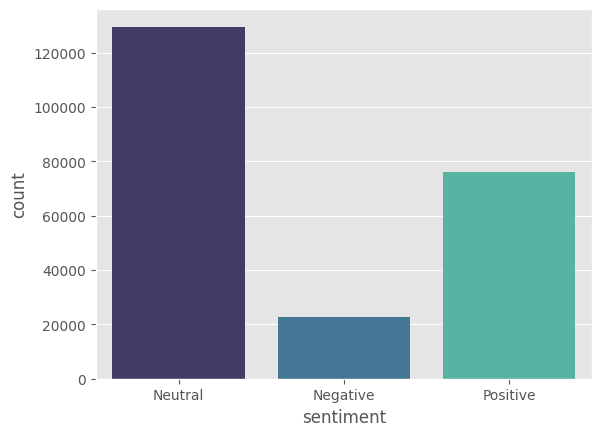

In [21]:
# Plot a bar chart
sns.countplot(x='sentiment', data=text_data, palette="mako")

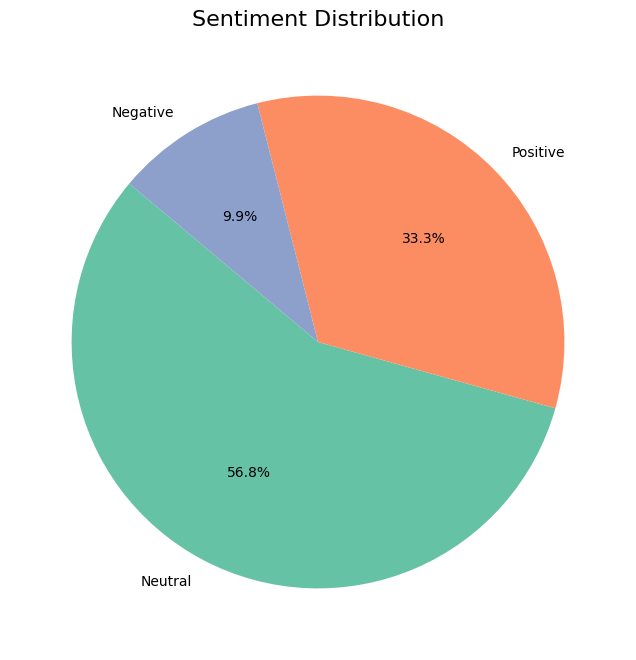

In [22]:
# Plot a pir chart
sentiment_counts = text_data['sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,  # Labels from the index
    autopct='%1.1f%%',  # Display percentages with 1 decimal place
    startangle=140,  # Rotate the pie chart for better readability
    colors=plt.cm.Set2.colors,
)

plt.title("Sentiment Distribution", fontsize=16)
plt.show()

### Word Cloud

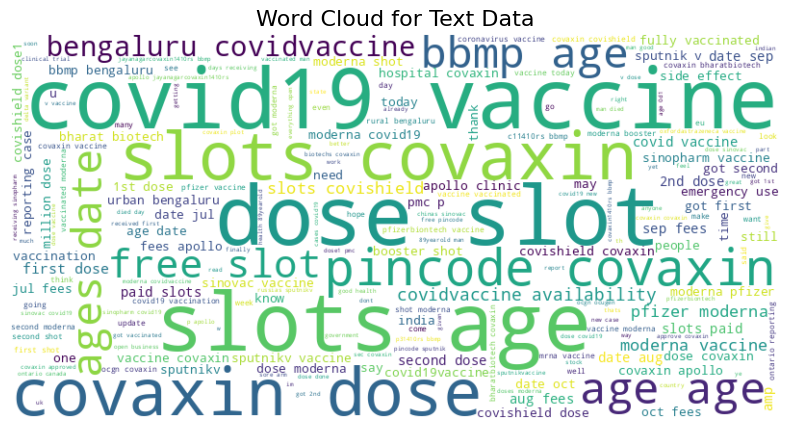

In [23]:
# Combine all the text data into one string
text_combined = " ".join(text_data['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide the axis
plt.title("Word Cloud for Text Data", fontsize=16)
plt.show()


In [24]:
text_pos = text_data[text_data['sentiment'] == 'Positive']
text_pos = text_pos.sort_values(['polarity'], ascending=False)
text_pos.head()

,text,sentiment,polarity
108629,covaxin phase 3 efficacy data 778 excellent re...,Positive,1.0
8424,excellent roundup similarities differences mod...,Positive,1.0
38363,turns sinovacs excellent inactivated vaccine c...,Positive,1.0
184236,hoafro ho approve best vaccine covaxin,Positive,1.0
15767,louisvilledad14 mine came dolly partons greate...,Positive,1.0


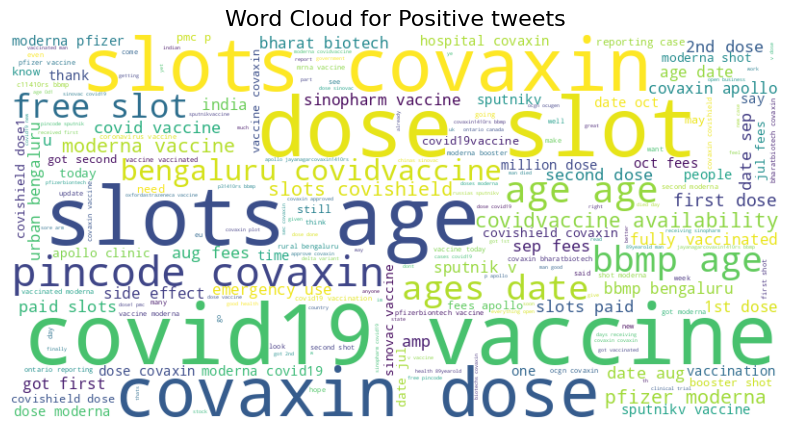

In [25]:
text_pos_combined = " ".join([word for word in text_pos['text']])

# Create a WordCloud object
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")  # Hide the axis
plt.title("Word Cloud for Positive tweets", fontsize=16)
plt.show()

## Build Model

In [26]:
vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75, min_df=5, max_features=1000)
text_matrix = vec.fit_transform(text_data['text'])

In [ ]:
print(vec.get_feature_names_out())

['01072021' '02072021' '02082021' '04' '06' '0d1' '0d2' '0d2 slots' '10'
 '100' '100 slots' '100d1' '11' '11410rs' '11410rs bbmp' '1145' '12'
 '1200' '122001' '122003' '1250' '13' '14' '14 covaxin'
 '14 gurgaoncovaxin' '1410' '1410 apollo' '1410 rxdx' '15' '16' '16072021'
 '17' '17072021' '18' '18 44' '18 ages' '18 date' '18062021' '1844'
 '1844 bbmp' '1844 rural' '1844 urban' '19' '19062021' '19072021' '1st'
 '1st dose' '20' '20 slots' '200' '20072021' '2021' '2021 fees' '21' '218'
 '22' '23' '23062021' '23072021' '24' '24 hours' '24062021' '24072021'
 '25' '25 slots' '25062021' '26' '26062021' '27' '28' '29' '29062021'
 '2nd' '2nd dose' '2nd moderna' '2nd shot' '30' '30 slots' '30062021' '31'
 '3rd' '40' '400602' '411014' '44' '44 date' '45' '45 0d1' '45 bbmp'
 '45 urban' '47' '50' '50 slots' '560001' '560003' '560010'
 '560010 covaxin' '560011' '560011 age' '560011 covaxin' '560037'
 '560037 age' '560038' '560038 covaxin' '560057' '560057 age' '560064'
 '560066' '560066 age' '560066

In [27]:
X = text_matrix
y = text_data['sentiment']

In [28]:
# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic regression

In [29]:
logreg_model = LogisticRegression(max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
# Model prediction
logreg_pred = logreg_model.predict(X_test)

# Evaluate model
print("Logistic Regression - Accuracy:", accuracy_score(y_test, logreg_pred))
print("Logistic Regression - Precision:", precision_score(y_test, logreg_pred, average='weighted'))
print("Logistic Regression - Recall:", recall_score(y_test, logreg_pred, average='weighted'))
print("Logistic Regression - F1-Score:", f1_score(y_test, logreg_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, logreg_pred))

Logistic Regression - Accuracy: 0.8624950703299592
Logistic Regression - Precision: 0.8730574000867216
Logistic Regression - Recall: 0.8624950703299592
Logistic Regression - F1-Score: 0.8522864542059008
Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.41      0.56      6709
     Neutral       0.82      0.99      0.90     38754
    Positive       0.96      0.77      0.86     23000

    accuracy                           0.86     68463
   macro avg       0.88      0.73      0.77     68463
weighted avg       0.87      0.86      0.85     68463



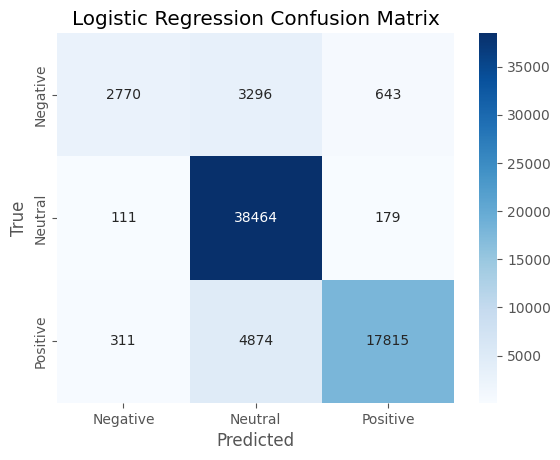

In [31]:
# Confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_pred)
sns.heatmap(logreg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Support Vector Machine (Optional)

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

In [ ]:
# Predict model
svm_pred = svm.predict(X_test)

# Evaluate model
print("SVM - Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM - Precision:", precision_score(y_test, svm_pred, average='weighted'))
print("SVM - Recall:", recall_score(y_test, svm_pred, average='weighted'))
print("SVM - F1-Score:", f1_score(y_test, svm_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, svm_pred))

### Naive Bayes (Optional)

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

NameError: name 'MultinomialNB' is not defined

In [ ]:
# Predict model
nb_pred = nb.predict(X_test)

# Evaluate model
print("Naive Bayes - Accuracy:", accuracy_score(y_test, nb_pred))
print("Naive Bayes - Precision:", precision_score(y_test, nb_pred, average='weighted'))
print("Naive Bayes - Recall:", recall_score(y_test, nb_pred, average='weighted'))
print("Naive Bayes - F1-Score:", f1_score(y_test, nb_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, nb_pred))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=y.unique())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression - Confusion Matrix")

# Confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred_svm, "SVM - Confusion Matrix")

# Confusion matrix for Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix")

## Deployment

In [32]:
# Save the Model and Vectorizer

import joblib

# Save the model and vectorizer
joblib.dump(logreg_model, 'logistic_regression_model.pkl')  # Save the trained Logistic Regression model
joblib.dump(vec, 'tfidf_vectorizer.pkl')                   # Save the TfidfVectorizer
print("Model and vectorizer saved!")


Model and vectorizer saved!


In [36]:
# Download the files

from google.colab import files
files.download('logistic_regression_model.pkl')
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# Test Flask

# Load the saved model and vectorizer
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Simulate user input and prediction
user_input = "‘This sucks’: Long COVID has taken thousands out of N.H. workforce, study says"
input_vectorized = vectorizer.transform([user_input])
prediction = model.predict(input_vectorized)[0]

print(f"Prediction for user input: {prediction}")


Prediction for user input: Negative
